## Linear Regression — End-to-End Workflow

This notebook walks through a full supervised regression pipeline for Linear Regression:
	•	Data Exploration: load, inspect, visualize
	•	Preprocessing: train/test split, (optional) scaling
	•	Modeling: from-scratch OLS (normal equation) + sklearn LinearRegression/Ridge/Lasso, with tuning
	•	Evaluation: MAE, MSE, RMSE, R^2, residuals, parity plots

Notes:
	•	OLS doesn’t require scaling, but regularized models (Ridge/Lasso) and gradient-based methods benefit from it.
	•	We use the scikit-learn Diabetes dataset (numeric features, continuous target).

## Setup

We’ll load libraries, set plotting defaults, and fix a seed for reproducibility.

In [1]:
# Imports & reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, Tuple, Union, List, Dict
from IPython.display import display

# sklearn utilities
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Optional viz
try:
    import seaborn as sns
except Exception:
    sns = None

np.random.seed(42)
plt.rcParams["figure.figsize"] = (6.8, 4.2)
plt.rcParams["axes.grid"] = True

## Data Exploration

We’ll load the Diabetes dataset, inspect shape/summary statistics, explore target distribution, and show correlations.

Shape: (442, 11)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


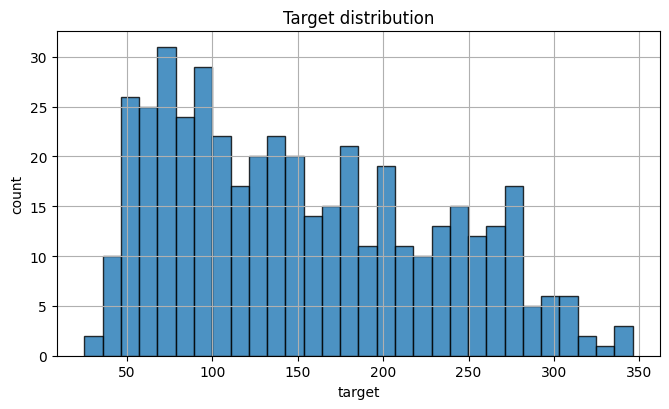

,corr_with_target
target,1.000000
bmi,0.586450
s5,0.565883
bp,0.441482
s4,0.430453
s6,0.382483
s1,0.212022
age,0.187889
s2,0.174054
sex,0.043062


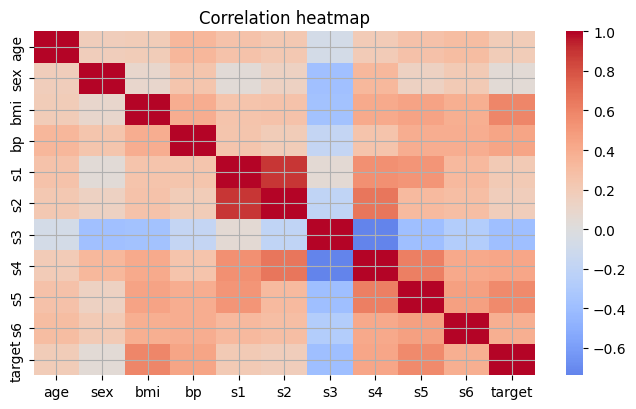

In [2]:
# Load dataset
diab = load_diabetes(as_frame=True)
X: pd.DataFrame = diab.data.copy()
y: pd.Series = pd.Series(diab.target, name="target")

df = X.copy()
df["target"] = y

print("Shape:", df.shape)
display(df.head())
display(df.describe())

# Target distribution
plt.hist(y, bins=30, edgecolor="k", alpha=0.8)
plt.title("Target distribution")
plt.xlabel("target"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# Correlations with target
corr = df.corr(numeric_only=True)["target"].sort_values(ascending=False)
display(corr.to_frame("corr_with_target"))

# Optional heatmap for all features
if sns is not None:
    try:
        sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)
        plt.title("Correlation heatmap")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("Skipping heatmap:", e)
else:
    print("Seaborn not installed; skipping heatmap.")

## Preprocessing
	•	We’ll perform a simple train/test split (regression → no stratification).
	•	We will use scaling inside Pipelines for Ridge/Lasso (helps regularization). OLS can work unscaled.

In [3]:
# Train/Test split (75/25)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (331, 10)  Test: (111, 10)


## Modeling

We’ll compare:
	1.	From-scratch OLS via the normal equation (with optional Ridge penalty)
	2.	sklearn LinearRegression (OLS)
	3.	Ridge and Lasso with small hyperparameter grids

We’ll also show an optional PolynomialFeatures + Ridge example.

In [4]:
class SimpleLinearRegressor:
    """
    Minimal Ordinary Least Squares with optional L2 regularization (Ridge).
    Uses the closed-form solution:
        theta = (X^T X + alpha * R)^(-1) X^T y
    where R does NOT penalize the intercept term.
    """
    def __init__(self, alpha: float = 0.0):
        self.alpha = float(alpha)
        self.coef_: Optional[np.ndarray] = None   # shape (n_features,)
        self.intercept_: Optional[float] = None
        self.theta_: Optional[np.ndarray] = None  # shape (n_features + 1,)

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.Series, np.ndarray]):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1, 1)
        n, d = X.shape

        # Augment with bias column
        X_aug = np.hstack([np.ones((n, 1)), X])  # [1, x1, x2, ...]
        # Regularization matrix (do not penalize intercept)
        R = np.eye(d + 1)
        R[0, 0] = 0.0

        # Closed-form (use pinv for stability)
        XtX = X_aug.T @ X_aug
        XtX_reg = XtX + self.alpha * R
        Xt_y = X_aug.T @ y
        theta = np.linalg.pinv(XtX_reg) @ Xt_y  # (d+1, 1)

        self.theta_ = theta.ravel()
        self.intercept_ = float(self.theta_[0])
        self.coef_ = self.theta_[1:].copy()
        return self

    def predict(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        return X @ self.coef_ + self.intercept_

In [5]:
# Build models
ols_scratch = SimpleLinearRegressor(alpha=0.0).fit(X_train, y_train)

ols_sklearn = LinearRegression()
ols_sklearn.fit(X_train, y_train)

ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(random_state=42))
])

lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(random_state=42, max_iter=20000))
])

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

print("Fitted: OLS(scratch), OLS(sklearn), Ridge, Lasso")

Fitted: OLS(scratch), OLS(sklearn), Ridge, Lasso


## Hyperparameter Tuning

Small grids for Ridge and Lasso (keep runtime modest).

In [6]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

ridge_grid = {
    "ridge__alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
}
ridge_gs = GridSearchCV(ridge, param_grid=ridge_grid, scoring="r2", cv=cv, n_jobs=-1)
ridge_gs.fit(X_train, y_train)
ridge_best = ridge_gs.best_estimator_

lasso_grid = {
    "lasso__alpha": [0.0005, 0.001, 0.005, 0.01, 0.05],
}
lasso_gs = GridSearchCV(lasso, param_grid=lasso_grid, scoring="r2", cv=cv, n_jobs=-1)
lasso_gs.fit(X_train, y_train)
lasso_best = lasso_gs.best_estimator_

print("Best Ridge:", ridge_gs.best_params_, " | CV R^2:", ridge_gs.best_score_)
print("Best Lasso:", lasso_gs.best_params_, " | CV R^2:", lasso_gs.best_score_)

Best Ridge: {'ridge__alpha': 1.0}  | CV R^2: 0.46141979230879004
Best Lasso: {'lasso__alpha': 0.05}  | CV R^2: 0.4613059397962421


## Evaluation

We’ll compute MAE, MSE, RMSE, and R^2; show residual vs fitted and parity (ŷ vs y) plots.

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_report(name: str, y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"MAE:  {mae: .4f}")
    print(f"MSE:  {mse: .4f}")
    print(f"RMSE: {rmse: .4f}")
    print(f"R^2:  {r2: .4f}")
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

def plot_residuals(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    resid = y_true - y_pred
    plt.scatter(y_pred, resid, edgecolor="k", alpha=0.8)
    plt.axhline(0, color="k", lw=1)
    plt.xlabel("Predicted")
    plt.ylabel("Residual (y - ŷ)")
    plt.title(title)
    plt.tight_layout(); plt.show()

def plot_parity(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.scatter(y_true, y_pred, edgecolor="k", alpha=0.8)
    plt.plot(lims, lims, "k--", lw=1)
    plt.xlabel("True y")
    plt.ylabel("Predicted ŷ")
    plt.title(title)
    plt.tight_layout(); plt.show()

In [8]:
# Predictions
y_pred_ols_scratch = ols_scratch.predict(X_test)
y_pred_ols_sk = ols_sklearn.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)
y_pred_ridge_best = ridge_best.predict(X_test)
y_pred_lasso_best = lasso_best.predict(X_test)

# Reports
metrics = {}
metrics["OLS (scratch)"] = regression_report("OLS (scratch)", y_test, y_pred_ols_scratch)
metrics["OLS (sklearn)"] = regression_report("OLS (sklearn)", y_test, y_pred_ols_sk)
metrics["Ridge"] = regression_report("Ridge", y_test, y_pred_ridge)
metrics["Lasso"] = regression_report("Lasso", y_test, y_pred_lasso)
metrics["Ridge (tuned)"] = regression_report("Ridge (tuned)", y_test, y_pred_ridge_best)
metrics["Lasso (tuned)"] = regression_report("Lasso (tuned)", y_test, y_pred_lasso_best)

display(pd.DataFrame(metrics).T)


=== OLS (scratch) ===
MAE:   41.5485
MSE:   2848.3107
RMSE:  53.3696
R^2:   0.4849

=== OLS (sklearn) ===
MAE:   41.5485
MSE:   2848.3107
RMSE:  53.3696
R^2:   0.4849

=== Ridge ===
MAE:   41.5073
MSE:   2842.8346
RMSE:  53.3182
R^2:   0.4859

=== Lasso ===
MAE:   41.3965
MSE:   2784.9848
RMSE:  52.7730
R^2:   0.4964

=== Ridge (tuned) ===
MAE:   41.5073
MSE:   2842.8346
RMSE:  53.3182
R^2:   0.4859

=== Lasso (tuned) ===
MAE:   41.5152
MSE:   2843.2113
RMSE:  53.3218
R^2:   0.4858


,MAE,MSE,RMSE,R2
OLS (scratch),41.548507,2848.310651,53.369567,0.484906
OLS (sklearn),41.548507,2848.310651,53.369567,0.484906
Ridge,41.507342,2842.834634,53.318239,0.485896
Lasso,41.396545,2784.984800,52.772955,0.496358
Ridge (tuned),41.507342,2842.834634,53.318239,0.485896
Lasso (tuned),41.515165,2843.211287,53.321771,0.485828


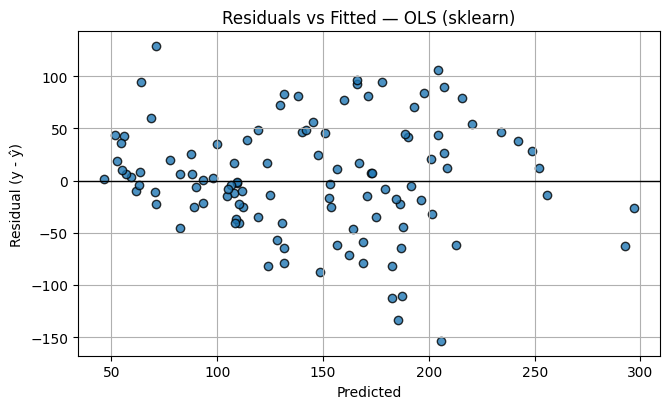

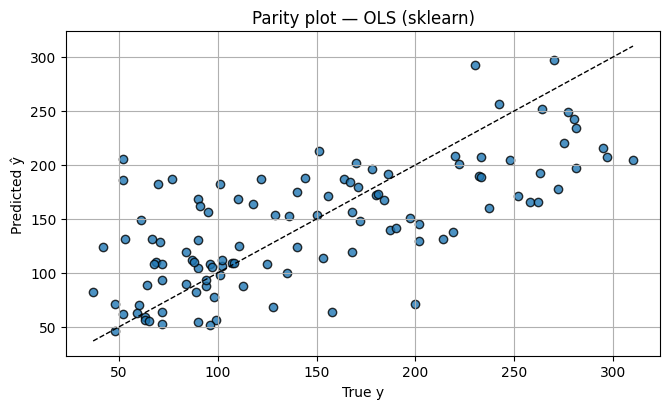

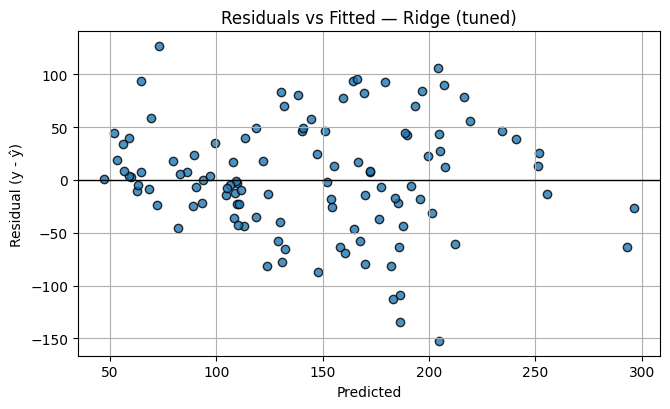

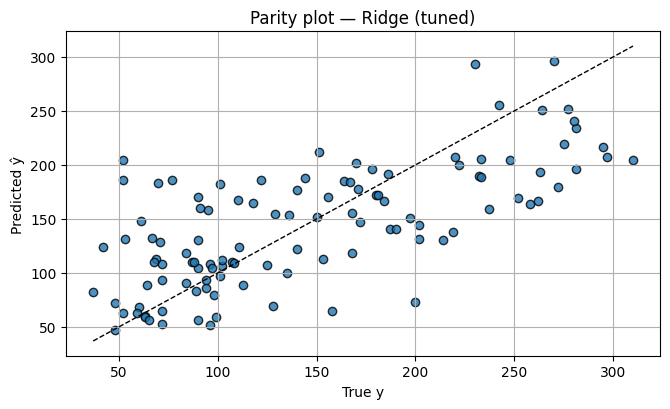

In [9]:
# Plots: residuals and parity for a couple of models
plot_residuals(y_test.to_numpy(), y_pred_ols_sk, "Residuals vs Fitted — OLS (sklearn)")
plot_parity(y_test.to_numpy(), y_pred_ols_sk, "Parity plot — OLS (sklearn)")

plot_residuals(y_test.to_numpy(), y_pred_ridge_best, "Residuals vs Fitted — Ridge (tuned)")
plot_parity(y_test.to_numpy(), y_pred_ridge_best, "Parity plot — Ridge (tuned)")

## Key Takeaways
	•	Linear Regression (OLS) minimizes squared error; closed-form via the normal equation.
	•	Regularization combats overfitting/ill-conditioning:
	•	Ridge (L2) shrinks coefficients, stable with correlated features.
	•	Lasso (L1) can drive some coefficients to exactly zero (feature selection).
	•	Metrics: MAE, MSE, RMSE, R^2; inspect residuals (should be roughly homoscedastic, centered).
	•	Scaling not required for OLS, but recommended for Lasso/Ridge and polynomial expansions.